## County Health Rankings

This data set is intended to demonstrate how various factors affect the health of counties in the United States, as well as highlight the dramatic range in health from county to county. These factors include access to affordable housing, access to well-paying jobs, education opportunities, and many others. This data is provided as a resource to help identify and address injustices and inequities in the health of counties in the United States.

The data set includes statistics on premature death rates, physical health, mental health, low birthweight, adult smoking, and countless others. The data is primarily numeric.

Documentation can be found at : https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2021.pdf


In [77]:
import pandas as pd
import numpy as np
import requests
import io

from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from pylab import cm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
%matplotlib inline

#### Read in the data 

In [78]:
url = 'http://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2021.csv'
response = requests.get(url)

file_object = io.StringIO(response.content.decode('utf-8'))
df = pd.read_csv(file_object,skiprows=[0])

In [79]:
df.head()

,statecode,countycode,fipscode,state,county,year,county_ranked,v001_rawvalue,v001_numerator,v001_denominator,...,v057_rawvalue,v057_numerator,v057_denominator,v057_cilow,v057_cihigh,v058_rawvalue,v058_numerator,v058_denominator,v058_cilow,v058_cihigh
0,0,0,0,US,United States,2021,NaN,6906.641094,3854074.0,915437195.0,...,0.507502,166582199,328239523,NaN,NaN,0.192690,NaN,NaN,NaN,NaN
1,1,0,1000,AL,Alabama,2021,NaN,9819.887431,82249.0,13651801.0,...,0.516739,2533668,4903185,NaN,NaN,0.409632,1957932.0,4779736.0,NaN,NaN
2,1,1,1001,AL,Autauga County,2021,1.0,7830.053484,787.0,155765.0,...,0.515080,28777,55869,NaN,NaN,0.420022,22921.0,54571.0,NaN,NaN
3,1,3,1003,AL,Baldwin County,2021,1.0,7680.477270,3147.0,600539.0,...,0.515096,114987,223234,NaN,NaN,0.422791,77060.0,182265.0,NaN,NaN
4,1,5,1005,AL,Barbour County,2021,1.0,11476.629416,515.0,69011.0,...,0.470793,11622,24686,NaN,NaN,0.677896,18613.0,27457.0,NaN,NaN


There are USA aggregate data and state aggregate level data, let's focus only on counties

In [80]:
df = df[df['countycode']!=0]

There are 16 Maine counties that we will be taking a close look at later on 

In [81]:
maine_fipscode = df[(df['state']=='ME')].fipscode
maine_county_labels = [' Andr',' Aroo',' Cumb', ' Fran', ' Hanc',' Kenn', ' Knox', ' Linc', ' Oxfo', 
                       ' Peno', ' Pisc', ' Saga', ' Some', ' Waldo', ' Wash', ' York']

There are a lot of columns we do need. In particular the numerator, denominator, confidence interval, ... columns for forming the raw_values are included. We get rid of them 

In [82]:
# select all the columns from CHR with raw values
## these columns contain the major health-related variables
all_cols = df.columns
col_names = [i for i in all_cols if 'rawvalue' in i]
print ('Number of CHR variables: ',len(col_names))
## We include the fipscode column because we want to get only the maine counties out later on
col_names.insert(0,"fipscode") 
df_sub = df[col_names]
df_sub = df_sub.set_index('fipscode')
df_sub.head()

Number of CHR variables:  79


,v001_rawvalue,v002_rawvalue,v036_rawvalue,v042_rawvalue,v037_rawvalue,v009_rawvalue,v011_rawvalue,v133_rawvalue,v070_rawvalue,v132_rawvalue,...,v053_rawvalue,v054_rawvalue,v055_rawvalue,v081_rawvalue,v080_rawvalue,v056_rawvalue,v126_rawvalue,v059_rawvalue,v057_rawvalue,v058_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,4.501499,4.850214,0.092018,0.198108,0.330,6.7,0.306,0.691301,...,0.159731,0.198643,0.004761,0.011742,0.001038,0.029909,0.737708,0.008033,0.515080,0.420022
1003,7680.477270,0.164607,3.647978,4.768294,0.082920,0.185133,0.300,7.8,0.247,0.737135,...,0.209780,0.086076,0.007803,0.010661,0.000690,0.047188,0.832073,0.007085,0.515096,0.422791
1005,11476.629416,0.298415,5.569267,5.590494,0.113553,0.255308,0.412,5.5,0.280,0.531668,...,0.196913,0.478287,0.006886,0.004699,0.002106,0.045248,0.455116,0.018907,0.470793,0.677896
1007,12172.562382,0.238533,4.894377,5.271114,0.102210,0.230848,0.374,7.6,0.334,0.162514,...,0.166696,0.210726,0.004599,0.002143,0.001161,0.027820,0.744083,0.003353,0.467313,0.683526
1009,11096.050649,0.219856,4.986622,5.357809,0.074305,0.229550,0.330,7.9,0.333,0.156345,...,0.187009,0.015080,0.006399,0.003199,0.001159,0.096531,0.867707,0.016185,0.507626,0.899515


We get rid of the columns that do not have at least 70% of the rows with values

In [83]:
#count and find the percentage of null values and concatenat the results
missing = pd.concat([df_sub.isnull().sum(), 100*df_sub.isnull().mean()], axis=1)
missing.columns = ['count', 'percentage']
smissing = missing.sort_values(by='count', ascending=False)
print(smissing)
good_cols = smissing[smissing['percentage'] < 30].index
good_cols = good_cols.sort_values()
df_sub2 = df_sub[good_cols]
df_sub2.head()

               count  percentage
v129_rawvalue   1912   60.852960
v015_rawvalue   1842   58.625080
v149_rawvalue   1836   58.434118
v138_rawvalue   1403   44.653087
v158_rawvalue   1321   42.043285
...              ...         ...
v136_rawvalue      0    0.000000
v060_rawvalue      0    0.000000
v145_rawvalue      0    0.000000
v002_rawvalue      0    0.000000
v144_rawvalue      0    0.000000

[79 rows x 2 columns]


,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,7830.053484,0.198392,0.130080,0.000468,6650.0,0.198108,0.330,23.764041,0.890000,0.027281,...,16.562431,0.732906,0.133759,0.42,155.095523,3.126968,2.917280,18.483525,0.805674,0.885166
1003,7680.477270,0.164607,0.167534,0.000702,3471.0,0.185133,0.300,26.006904,0.880000,0.027258,...,14.350620,0.752453,0.111740,0.46,133.604842,3.192381,3.037912,19.287661,0.818164,0.908062
1005,11476.629416,0.298415,0.176732,0.000322,5314.0,0.255308,0.412,37.114262,0.820690,0.037952,...,21.211240,0.608989,0.142707,0.39,102.459673,2.389161,2.008629,11.325918,0.605243,0.732131
1007,12172.562382,0.238533,0.134299,0.000536,6690.0,0.230848,0.374,37.786446,0.880000,0.030628,...,20.410337,0.744159,0.087444,0.40,26.588748,2.688775,2.563367,16.955833,0.692062,0.790574
1009,11096.050649,0.219856,0.179347,0.000207,4440.0,0.229550,0.330,31.239778,0.929256,0.026687,...,21.449131,0.787787,0.078048,0.40,43.309562,2.901714,2.781497,20.022098,0.730081,0.804906


I do a demonstration plot that should be helpful for the Assignment 3 work 

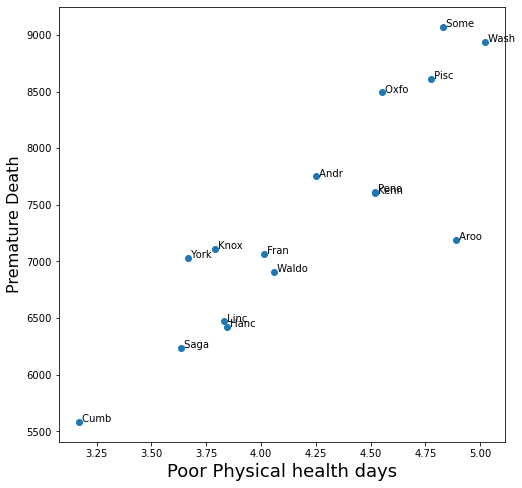

In [84]:
fig, ax = plt.subplots(figsize=(8,8))

# a boolean series gets created with true values for maine counties 
maine_counties = df_sub2.index.isin(maine_fipscode)

x_axis = df_sub2[maine_counties]['v036_rawvalue']
y_axis = df_sub2[maine_counties]['v001_rawvalue']
ax.scatter(x_axis, y_axis)

ax.set_xlabel('Poor Physical health days', fontsize=18)
ax.set_ylabel('Premature Death', fontsize=16)

for i, label in enumerate(maine_county_labels):
    plt.annotate(label, (x_axis.iloc[i], y_axis.iloc[i]))
    
plt.show()

In [85]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
prepared_data = pipeline.fit_transform(df_sub2)

In [86]:
prepared_data_df = pd.DataFrame(prepared_data)
prepared_data_df.index = df_sub2.index
prepared_data_df.columns = df_sub2.columns
prepared_data_df

,v001_rawvalue,v002_rawvalue,v003_rawvalue,v004_rawvalue,v005_rawvalue,v009_rawvalue,v011_rawvalue,v014_rawvalue,v021_rawvalue,v023_rawvalue,...,v148_rawvalue,v153_rawvalue,v154_rawvalue,v155_rawvalue,v156_rawvalue,v159_rawvalue,v160_rawvalue,v161_rawvalue,v166_rawvalue,v168_rawvalue
fipscode,,,,,,,,,,,,,,,,,,,,,
1001,-0.247243,-0.054049,-0.101889,-0.205470,1.182201,-0.364320,-0.075332,-0.313281,0.131797,-0.857910,...,0.135078,0.203832,0.705685,-0.109118,0.004158,0.454784,-0.221560,0.004928,0.584326,0.250498
1003,-0.302948,-0.714412,0.509630,0.461484,-0.653917,-0.676814,-0.577581,-0.141947,-0.024877,-0.859441,...,-0.228653,0.438010,0.075119,0.291640,-0.069242,0.706539,0.189496,0.121032,0.725538,0.616148
1005,1.110815,1.901005,0.659803,-0.621592,0.410558,1.013361,1.297483,0.706552,-0.954114,-0.138927,...,0.899573,-1.280789,0.961944,-0.409686,-0.175616,-2.384825,-3.317797,-1.028510,-1.681706,-2.193532
1007,1.369995,0.730548,-0.032999,-0.011500,1.205304,0.424245,0.661300,0.757900,-0.024877,-0.632443,...,0.767864,0.338645,-0.620675,-0.309497,-0.434748,-1.231696,-1.427522,-0.215645,-0.700148,-1.260174
1009,0.969080,0.365492,0.702493,-0.946490,-0.094244,0.392969,-0.075332,0.257796,0.746833,-0.897957,...,0.938694,0.861341,-0.889766,-0.309497,-0.377639,-0.412154,-0.684242,0.227072,-0.270312,-1.031292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,-0.267719,-0.717821,0.038501,-0.412658,-1.189908,-0.677941,-0.527356,0.106786,-1.235965,-0.073688,...,1.188040,0.555074,-0.717269,-0.109118,0.223189,0.942707,1.480645,1.608381,0.972909,0.932438
56039,-2.053617,-1.701282,0.186108,1.547819,-0.821414,-2.032550,-3.758494,-1.414909,-0.103214,-0.861815,...,-1.172476,-1.339862,-0.110378,0.992966,-0.034947,2.040218,2.126417,-0.621607,1.325967,1.315560
56041,-0.153766,-0.625928,0.144279,-0.134209,-1.018945,-0.134607,0.292984,-0.010478,-0.558547,-0.063613,...,0.937087,0.655035,-1.388798,-0.810444,-0.089693,0.519513,1.240118,1.539990,1.598231,0.925219


In [87]:
y = prepared_data_df['v001_rawvalue']
X = prepared_data_df.drop('v001_rawvalue', axis=1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=42)

In [89]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [90]:
from sklearn.metrics import mean_squared_error
y_pred = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2552431228232307

In [91]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[71]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [92]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\Sage\AppData\Local\Temp\ipykernel_27116\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [93]:
keras_reg.fit(X_train, y_train, epochs=100, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


C:\Users\Sage\anaconda3\envs\Project3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


71/71 [==============================] - 0s 743us/step - loss: 0.7218
Epoch 2/100
71/71 [==============================] - 0s 883us/step - loss: 0.3573
Epoch 3/100
71/71 [==============================] - 0s 784us/step - loss: 0.2997
Epoch 4/100
71/71 [==============================] - 0s 670us/step - loss: 0.2648
Epoch 5/100
71/71 [==============================] - 0s 710us/step - loss: 0.2397
Epoch 6/100
71/71 [==============================] - 0s 604us/step - loss: 0.2228
Epoch 7/100
71/71 [==============================] - 0s 826us/step - loss: 0.2079
Epoch 8/100
71/71 [==============================] - 0s 1ms/step - loss: 0.1965
Epoch 9/100
71/71 [==============================] - 0s 841us/step - loss: 0.1870
Epoch 10/100
71/71 [==============================] - 0s 784us/step - loss: 0.1788
Epoch 11/100
71/71 [==============================] - 0s 769us/step - loss: 0.1716
Epoch 12/100
71/71 [==============================] - 0s 926us/step - loss: 0.1655
Epoch 13/100
71/71 [=======

In [94]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

In [95]:
# rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
# rnd_search_cv.fit(X_train, y_train, epochs=100, callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [96]:
# rnd_search_cv.best_params_

In [97]:
model = build_model(n_hidden=0, n_neurons=22, learning_rate=0.005)

C:\Users\Sage\anaconda3\envs\Project3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [98]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
71/71 [==============================] - 0s 648us/step - loss: 1.1082
Epoch 2/20
71/71 [==============================] - 0s 628us/step - loss: 0.4294
Epoch 3/20
71/71 [==============================] - 0s 654us/step - loss: 0.2701
Epoch 4/20
71/71 [==============================] - 0s 639us/step - loss: 0.1966
Epoch 5/20
71/71 [==============================] - 0s 598us/step - loss: 0.1563
Epoch 6/20
71/71 [==============================] - 0s 580us/step - loss: 0.1327
Epoch 7/20
71/71 [==============================] - 0s 627us/step - loss: 0.1169
Epoch 8/20
71/71 [==============================] - 0s 589us/step - loss: 0.1060
Epoch 9/20
71/71 [==============================] - 0s 603us/step - loss: 0.0992
Epoch 10/20
71/71 [==============================] - 0s 612us/step - loss: 0.0940
Epoch 11/20
71/71 [==============================] - 0s 612us/step - loss: 0.0897
Epoch 12/20
71/71 [==============================] - 0s 560us/step - loss: 0.0861
Epoch 13/20
71/71 [======

In [99]:
mse = model.evaluate(X_val, y_val)
rmse = np.sqrt(mse)
rmse

8/8 [==============================] - 0s 712us/step - loss: 0.0705


0.2654992815841323

In [100]:
y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2479459289431052

In [101]:
mse = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
rmse

20/20 [==============================] - 0s 577us/step - loss: 0.0712


0.26691364006367463

I used what the book did to find the best params for the neural network (Pg 320-22). I'm not certain I did it perfectly, but either way the final results said that 0 hidden layers and 22 neurons was the best. I find this to be somewhat odd because if there are 0 layers then would the number of neurons even matter at that point? Either way though the results were actually pretty good. The linear regression rmse was about 0.248, while the neural network was about 0.268. The linear regression was ultimately better but the neural network came very close to matching it.

Another little note, I commented the actual search for the best params out becuase it takes around 3 mins to run and I don't want to put you through that if you run this notebook.